In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
#from fastai.structured import *
#from fastai.column_data import *
#np.set_printoptions(threshold=50, edgeitems=20)
import pandas as pd
import numpy as np
import re
from isoweek import Week
import sklearn, warnings
import datetime, math

PATH='data/rossmann/'

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.nn.init import kaiming_uniform, kaiming_normal
from torchvision import transforms

In [52]:
from dllib.model import model_summary
from dllib import train as train

# Start from Line 75 of Fast AI Lesson 3 Notebook in DL1 course 
https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb

In [5]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [6]:
joined.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [7]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

844338

In [8]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [9]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [10]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [11]:
def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.
    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category {a : 1, b : 2}
    >>> df2 = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['b', 'a', 'a']})
    >>> apply_cats(df2, df)
           col1 col2
        0     1    b
        1     2    a
        2     3    a
    now the type of col is category {a : 1, b : 2}
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)


In [12]:
apply_cats(joined_test, joined)

In [13]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

In [14]:
def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    """ Get a list of index values for Validation set from a dataset
    
    Arguments:
        n : int, Total number of elements in the data set.
        cv_idx : int, starting index [idx_start = cv_idx*int(val_pct*n)] 
        val_pct : (int, float), validation set percentage 
        seed : seed value for RandomState
        
    Returns:
        list of indexes 
    """
    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

In [15]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [17]:
def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [18]:
def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

In [19]:
def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1

In [20]:
from pandas.api.types import is_string_dtype, is_numeric_dtype
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    ignore_flds: A list of fields that are ignored during processing.
    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [21]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

In [22]:
joined_test = joined_test.set_index("Date")

In [23]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in this post on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [24]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); print(train_size)
val_idx = list(range(train_size, len(df)))

112500


In [198]:
class ColumnarDataset(Dataset):
    def __init__(self, cats, conts, y, is_reg=True, is_multi=False):
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = (np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1)))
        self.conts = (np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1)))
        self.y = (np.zeros((n,1)) if y is None else y)
        if is_reg:
            self.y =  self.y[:,None]
        self.is_reg = is_reg
        self.is_multi = is_multi

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

    @classmethod
    def from_data_frames(cls, df_cat, df_cont, y=None, is_reg=True, is_multi=False):
        cat_cols = [c.values for n,c in df_cat.items()]
        cont_cols = [c.values for n,c in df_cont.items()]
        return cls(cat_cols, cont_cols, y, is_reg, is_multi)

    @classmethod
    def from_data_frame(cls, df, cat_flds, y=None, is_reg=True, is_multi=False):
        return cls.from_data_frames(df[cat_flds], df.drop(cat_flds, axis=1), y, is_reg, is_multi)

In [26]:
def split_by_idx(idxs, *a):
    """
    Split each array passed as *a, to a pair of arrays like this (elements selected by idxs,  the remaining elements)
    This can be used to split multiple arrays containing training data to validation and training set.
    :param idxs [int]: list of indexes selected
    :param a list: list of np.array, each array should have same amount of elements in the first dimension
    :return: list of tuples, each containing a split of corresponding array from *a.
            First element of each tuple is an array composed from elements selected by idxs,
            second element is an array of remaining elements.
    """
    mask = np.zeros(len(a[0]),dtype=bool)
    mask[np.array(idxs)] = True
    return [(o[mask],o[~mask]) for o in a]

In [195]:
((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idx, df, yl.astype(np.float32))

In [199]:
column_datasets = {'train': ColumnarDataset.from_data_frame(trn_df, cat_vars, trn_y),
                   'val': ColumnarDataset.from_data_frame(val_df, cat_vars, val_y)}

In [208]:
len(column_datasets['train'].y)

112500

In [209]:
column_dataloaders = {x: torch.utils.data.DataLoader(column_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

In [210]:
len(column_dataloaders['train'])

879

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [202]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [203]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

In [204]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

We use the cardinality of each variable (that is, its number of unique values) to decide how large to make its embeddings. Each level will be associated with a vector with length defined as below.

In [205]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [35]:
def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)

In [252]:
class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range
        self.is_reg = is_reg
        self.is_multi = is_multi

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if not self.is_reg:
            if self.is_multi:
                x = F.sigmoid(x)
            else:
                x = F.log_softmax(x)
        elif self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x
    
    def inv_y(self,a): return np.exp(a)

    def exp_rmspe(self,y_pred, targ):
        targ = self.inv_y(targ.cpu().data)
        pct_var = (targ - self.inv_y(y_pred.cpu().data))/targ
        return math.sqrt((pct_var**2).mean())

    def calculate_loss(self, outputs, targets, **kwargs):
        return F.mse_loss(input=outputs, target=targets)
        
    def calculate_metrics(self, outputs, targets, **kwargs):
        classification_accuracy = 1-self.exp_rmspe(outputs,targets)
        return classification_accuracy

In [168]:
max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [169]:
y_range

(0, 12.63454087942548)

In [289]:
model = MixedInputModel(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

C:\Users\kswamy\AppData\Local\conda\conda\envs\myfastai1\lib\site-packages\ipykernel_launcher.py:15: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  from ipykernel import kernelapp as app
C:\Users\kswamy\AppData\Local\conda\conda\envs\myfastai1\lib\site-packages\ipykernel_launcher.py:17: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [290]:
optimizer_col= optim.Adam(model.parameters(),lr=0.001)

In [268]:
#optimizer_col = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [291]:
train_col = train.Trainer(model,column_dataloaders['train'],column_dataloaders['val'],optimizer_col)

In [282]:
*test1, target1 = next(iter(column_dataloaders['train']))

In [230]:
target1.size(0)

128

In [222]:
from dllib.core import V
test1 = V(test1)

In [283]:
pred1 = model(*test1)

In [284]:
F.mse_loss(input=pred1, target=target1)

tensor(7.5281)

Trying learning rates between 1e-05 and 10 over 30 steps (1 epochs)
Epoch 0/0
----------


  0%|          | 0/879 [00:00<?, ?it/s]

Iteration No:1 Learn rate 1.00E-05 Batch Loss: 0.0131 Batch Accuracy: 0.8836 
Iteration No:2 Learn rate 1.58E-05 Batch Loss: 0.0092 Batch Accuracy: 0.9027 
Iteration No:3 Learn rate 2.51E-05 Batch Loss: 0.0086 Batch Accuracy: 0.9066 


  0%|          | 3/879 [00:00<00:31, 27.96it/s]

Iteration No:4 Learn rate 3.98E-05 Batch Loss: 0.0090 Batch Accuracy: 0.9068 
Iteration No:5 Learn rate 6.31E-05 Batch Loss: 0.0093 Batch Accuracy: 0.8950 
Iteration No:6 Learn rate 1.00E-04 Batch Loss: 0.0090 Batch Accuracy: 0.9072 


  1%|          | 6/879 [00:00<00:30, 28.91it/s]

Iteration No:7 Learn rate 1.58E-04 Batch Loss: 0.0073 Batch Accuracy: 0.9152 
Iteration No:8 Learn rate 2.51E-04 Batch Loss: 0.0080 Batch Accuracy: 0.9118 
Iteration No:9 Learn rate 3.98E-04 Batch Loss: 0.0103 Batch Accuracy: 0.8811 


  1%|          | 9/879 [00:00<00:30, 28.86it/s]

Iteration No:10 Learn rate 6.31E-04 Batch Loss: 0.0125 Batch Accuracy: 0.8836 
Iteration No:11 Learn rate 1.00E-03 Batch Loss: 0.0095 Batch Accuracy: 0.8980 
Iteration No:12 Learn rate 1.58E-03 Batch Loss: 0.0084 Batch Accuracy: 0.9097 
Iteration No:13 Learn rate 2.51E-03 Batch Loss: 0.0084 Batch Accuracy: 0.9071 


  1%|▏         | 13/879 [00:00<00:29, 29.33it/s]

Iteration No:14 Learn rate 3.98E-03 Batch Loss: 0.0160 Batch Accuracy: 0.8630 
Iteration No:15 Learn rate 6.31E-03 Batch Loss: 0.0362 Batch Accuracy: 0.8308 
Iteration No:16 Learn rate 1.00E-02 Batch Loss: 0.2797 Batch Accuracy: 0.2790 
Iteration No:17 Learn rate 1.58E-02 Batch Loss: 3.7924 Batch Accuracy: 0.1536 


  2%|▏         | 17/879 [00:00<00:29, 29.64it/s]

Iteration No:18 Learn rate 2.51E-02 Batch Loss: 0.1330 Batch Accuracy: 0.5033 
Iteration No:19 Learn rate 3.98E-02 Batch Loss: 0.4557 Batch Accuracy: 0.0753 
Iteration No:20 Learn rate 6.31E-02 Batch Loss: 15.1961 Batch Accuracy: -55.3459 


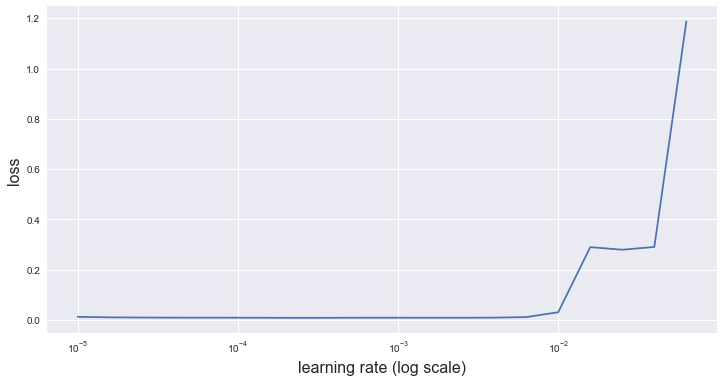

In [304]:
train_col.lr_find(steps=30)

Epoch 0/1
----------


100%|██████████| 879/879 [00:21<00:00, 40.72it/s]


train Loss: 0.1372 Acc: 0.6015


100%|██████████| 293/293 [00:01<00:00, 223.77it/s]


val Loss: 0.0339 Acc: 0.7772

Epoch 1/1
----------


100%|██████████| 879/879 [00:23<00:00, 37.39it/s]


train Loss: 0.0277 Acc: 0.8225


100%|██████████| 293/293 [00:01<00:00, 232.25it/s]


val Loss: 0.0217 Acc: 0.8466

Training complete in 0m 48s
Best val Acc: 0.846603


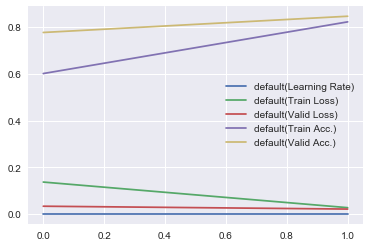

In [293]:
train_col.train_model(num_epochs=2,optimizer=optimizer_col)

In [294]:
import dllib.lr_sched as lr_sched

Epoch 0/2
----------


100%|██████████| 879/879 [00:23<00:00, 37.06it/s]


train Loss: 0.0187 Acc: 0.8559


100%|██████████| 293/293 [00:01<00:00, 219.47it/s]


val Loss: 0.0149 Acc: 0.8705

Epoch 1/2
----------


100%|██████████| 879/879 [00:23<00:00, 37.26it/s]


train Loss: 0.0171 Acc: 0.8635


100%|██████████| 293/293 [00:01<00:00, 212.64it/s]


val Loss: 0.0138 Acc: 0.8774

Epoch 2/2
----------


100%|██████████| 879/879 [00:24<00:00, 35.87it/s]


train Loss: 0.0161 Acc: 0.8686


100%|██████████| 293/293 [00:01<00:00, 213.44it/s]


val Loss: 0.0131 Acc: 0.8813

Training complete in 1m 16s
Best val Acc: 0.881301


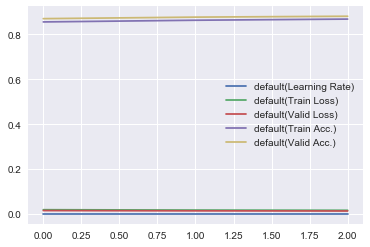

In [296]:
lr_scheduler_col = lr_sched.myCosineAnnealingLR(optimizer_col,879,cycle_mult=1.0)
train_col.train_model(num_epochs=3,scheduler=lr_scheduler_col)

Epoch 0/2
----------


100%|██████████| 879/879 [00:20<00:00, 41.90it/s]


train Loss: 0.0110 Acc: 0.8923


100%|██████████| 293/293 [00:01<00:00, 227.06it/s]


val Loss: 0.0112 Acc: 0.8919

Epoch 1/2
----------


100%|██████████| 879/879 [00:21<00:00, 40.55it/s]


train Loss: 0.0103 Acc: 0.8958


100%|██████████| 293/293 [00:01<00:00, 225.28it/s]


val Loss: 0.0110 Acc: 0.8934

Epoch 2/2
----------


100%|██████████| 879/879 [00:22<00:00, 39.12it/s]


train Loss: 0.0101 Acc: 0.8972


100%|██████████| 293/293 [00:01<00:00, 218.71it/s]


val Loss: 0.0114 Acc: 0.8913

Training complete in 1m 9s
Best val Acc: 0.893448


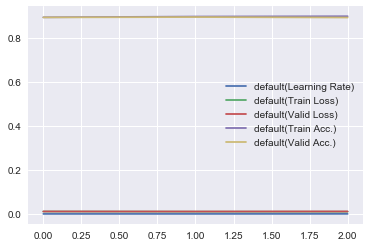

In [305]:
optimizer_col= optim.Adam(model.parameters(),lr=0.0005)
lr_scheduler_col = lr_sched.myCosineAnnealingLR(optimizer_col,400,cycle_mult=1.5)
train_col.train_model(num_epochs=3,optimizer=optimizer_col,scheduler=lr_scheduler_col)

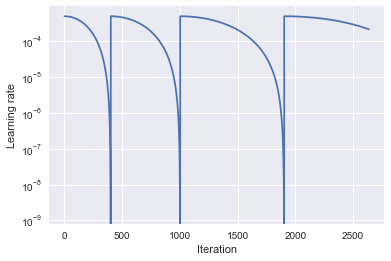

In [306]:
train_col.plot_lr()

# All

In [307]:
samp_size = n
joined_samp = joined.set_index("Date")

In [308]:
len(joined_samp)

844338

In [309]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

In [310]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); print(train_size)
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

633253


In [311]:
((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idx, df, yl.astype(np.float32))

In [312]:
column_datasets = {'train': ColumnarDataset.from_data_frame(trn_df, cat_vars, trn_y),
                   'val': ColumnarDataset.from_data_frame(val_df, cat_vars, val_y)}

In [313]:
column_dataloaders = {x: torch.utils.data.DataLoader(column_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

In [314]:
optimizer_col= optim.Adam(model.parameters(),lr=0.001)

In [315]:
train_col = train.Trainer(model,column_dataloaders['train'],column_dataloaders['val'],optimizer_col)

Epoch 0/1
----------


100%|██████████| 6297/6297 [03:04<00:00, 34.14it/s]


train Loss: 0.0132 Acc: 0.8783


100%|██████████| 300/300 [00:01<00:00, 219.85it/s]


val Loss: 0.0135 Acc: 0.8869

Epoch 1/1
----------


100%|██████████| 6297/6297 [03:17<00:00, 31.90it/s]


train Loss: 0.0106 Acc: 0.8916


100%|██████████| 300/300 [00:01<00:00, 221.86it/s]


val Loss: 0.0159 Acc: 0.8832

Training complete in 6m 25s
Best val Acc: 0.886880


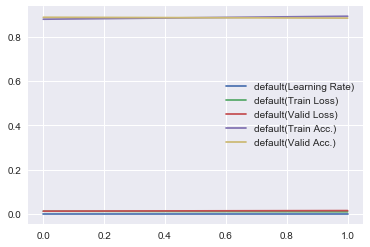

In [316]:
train_col.train_model(num_epochs=2)

Epoch 0/2
----------


100%|██████████| 6297/6297 [02:49<00:00, 37.12it/s]


train Loss: 0.0096 Acc: 0.8966


100%|██████████| 300/300 [00:01<00:00, 202.84it/s]


val Loss: 0.0122 Acc: 0.8935

Epoch 1/2
----------


100%|██████████| 6297/6297 [03:16<00:00, 32.04it/s]


train Loss: 0.0090 Acc: 0.9006


100%|██████████| 300/300 [00:01<00:00, 206.92it/s]


val Loss: 0.0117 Acc: 0.8952

Epoch 2/2
----------


100%|██████████| 6297/6297 [03:14<00:00, 32.32it/s]


train Loss: 0.0085 Acc: 0.9036


100%|██████████| 300/300 [00:01<00:00, 211.00it/s]


val Loss: 0.0114 Acc: 0.8974

Training complete in 9m 26s
Best val Acc: 0.897405


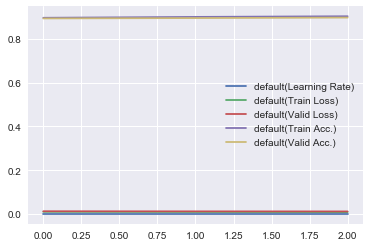

In [317]:
optimizer_col= optim.Adam(model.parameters(),lr=0.001)
lr_scheduler_col = lr_sched.myCosineAnnealingLR(optimizer_col,6297,cycle_mult=1.0)
train_col.train_model(num_epochs=3,optimizer=optimizer_col,scheduler=lr_scheduler_col)

In [75]:
model

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(1116, 50)
    (1): Embedding(8, 4)
    (2): Embedding(4, 2)
    (3): Embedding(13, 7)
    (4): Embedding(32, 16)
    (5): Embedding(3, 2)
    (6): Embedding(26, 13)
    (7): Embedding(27, 14)
    (8): Embedding(5, 3)
    (9): Embedding(4, 2)
    (10): Embedding(4, 2)
    (11): Embedding(24, 12)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 27)
    (15): Embedding(22, 11)
    (16): Embedding(7, 4)
    (17): Embedding(7, 4)
    (18): Embedding(4, 2)
    (19): Embedding(4, 2)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
  )
  (lins): ModuleList(
    (0): Linear(in_features=217, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outp): Linear(in

In [143]:
# Get a batch of training data
cats,conts,y = next(iter(column_dataloaders['train']))

In [170]:
model(cats[0:10],conts[0:10])

tensor([[ 6.0971],
        [ 7.6578],
        [ 7.7440],
        [ 8.5469],
        [ 7.1487],
        [ 8.1876],
        [ 7.4198],
        [ 7.2720],
        [ 6.7933],
        [ 6.2678]])

In [171]:
input_data = [cats[0:10],conts[0:10]]

In [172]:
model_summary(model,input_data)

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', tensor(55800))])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 4]),
                           ('trainable', True),
                           ('nb_params', tensor(32))])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', tensor(8))])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 7]),
                           ('trainable', True),
                           ('nb_params', tensor(91))])),
             ('Embedding-5',
              Or